# Comparison of the constrained time series with CMIP6 model aerosol forcing

I realised that after publishing this paper that nowhere in it do we actually answer the question of "is CMIP6 aerosol forcing too strong?" This again will not definitely answer yes or no, but will visually compare the constrained CMIP6 time series against the models from 1850 to 2019.

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as pl
import os
import wquantiles
import matplotlib.gridspec as gridspec
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from tqdm import tqdm_notebook
from netCDF4 import Dataset
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

import h5py

In [2]:
def save_dict_to_hdf5(dic, filename):
    """
    ....
    """
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    """
    ....
    """
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

def load_dict_from_hdf5(filename):
    """
    ....
    """
    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/')

def recursively_load_dict_contents_from_group(h5file, path):
    """
    ....
    """
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
    return ans

In [3]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 11
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

In [4]:
models = ['CanESM5','E3SM','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM','UKESM1-0-LL']

colors = {
    'CMIP6-constrained' : '0.3',
    'CanESM5'        : 'red',#'#1e4c24',
    'E3SM'           : 'darkorange',
    'GFDL-ESM4'      : 'yellowgreen', 
    'GFDL-CM4'       : 'yellow',#'green',
    'GISS-E2-1-G'    : 'green',#'#771d7b',
    'HadGEM3-GC31-LL': 'turquoise',
    'IPSL-CM6A-LR'   : 'teal',
    'MIROC6'         : 'blue',#b85fb7',
    'MRI-ESM2-0'     : 'blueviolet',
    'NorESM2-LM'     : 'purple',#'red',
    'UKESM1-0-LL'    : 'crimson',
    'observations'   : 'black',
    'Oslo-CTM3'      : 'pink',
}

ls = {
    'CMIP6-constrained'  : '-',
    'CanESM5'        : '-',
    'E3SM'           : '-',
    'GFDL-ESM4'      : '-',
    'GFDL-CM4'       : '-',
    'GISS-E2-1-G'    : '-',
    'HadGEM3-GC31-LL': '-',
    'IPSL-CM6A-LR'   : '-',
    'MIROC6'         : '-',
    'MRI-ESM2-0'     : '-',
    'NorESM2-LM'     : '-',
    'UKESM1-0-LL'    : '-',
    'Oslo-CTM3'      : '-',
    'observations'   : '-',
}

In [5]:
# load large datafiles calculated previously
ERFari = load_dict_from_hdf5('../data_output/results/ERFari.h5')
ERFaci = load_dict_from_hdf5('../data_output/results/ERFaci.h5')
ks     = load_dict_from_hdf5('../data_output/results/knutti_score.h5')

In [6]:
pc = load_dict_from_hdf5('../data_output/results/pc.h5')

In [7]:
intvar = np.loadtxt('../data_output/piControl/internal_variability_piControl.txt')

In [8]:
expts = ['CMIP6-constrained','CanESM5','E3SM','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM','UKESM1-0-LL']

In [9]:
endyear = {
    'CanESM5'    : 2100,
    'MIROC6'     : 2100,
    'NorESM2-LM' : 2100,
    'GISS-E2-1-G': 2100,
    'HadGEM3-GC31-LL': 2099,
    'GFDL-CM4'   : 2100,
    'E3SM'       : 2014,
    'UKESM1-0-LL': 2014,
    'GFDL-ESM4'  : 2014,
    'IPSL-CM6A-LR': 2100,
    'MRI-ESM2-0' : 2014,
}

startyear = {
    'CanESM5'    : 1850,
    'MIROC6'     : 1850,
    'NorESM2-LM' : 1850,
    'GISS-E2-1-G': 1850,
    'HadGEM3-GC31-LL': 1850,
    'GFDL-CM4'   : 1850,
    'E3SM'       : 1870,
    'GFDL-ESM4'  : 1850,
    'UKESM1-0-LL': 1850,
    'IPSL-CM6A-LR': 1850,
    'MRI-ESM2-0': 1850,
}

In [10]:
model_erf = {}
models = [
    'CanESM5', 
    'E3SM', 
    'GFDL-CM4', 
    'GFDL-ESM4', 
    'GISS-E2-1-G',
    'HadGEM3-GC31-LL',
    'IPSL-CM6A-LR',
    'MIROC6',
    'MRI-ESM2-0',
    'NorESM2-LM',
    'UKESM1-0-LL'
]

for model in models:
    model_erf[model] = pd.read_csv('../data_output/rfmip_aprp/%s.csv' % model, index_col=0)['erf'].values

In [11]:
model_erf

{'CanESM5': array([-0.056411  ,  0.00219252,  0.04074844,  0.01102605, -0.06857881,
         0.01494537,  0.00593752, -0.04488797, -0.07926764, -0.11814266,
        -0.13781422, -0.13485952, -0.0793694 ,  0.09855588, -0.00592292,
        -0.04818681,  0.07997091,  0.00708209,  0.01093791,  0.02436043,
        -0.1342439 , -0.10611849, -0.13979065, -0.0468199 , -0.03966766,
         0.07466531,  0.1049566 , -0.08370412,  0.02922811, -0.03862544,
        -0.06893918, -0.06830068, -0.09959986, -0.09485167, -0.07251751,
        -0.08657304, -0.16458178, -0.03806332,  0.00642813,  0.01003136,
        -0.03786649, -0.26218052, -0.11265555, -0.18845381, -0.22777006,
        -0.10155901, -0.22684949, -0.13495729, -0.13336149, -0.11458258,
        -0.13261155, -0.0452208 , -0.20232042, -0.25250868, -0.31541381,
        -0.25610084, -0.39002423, -0.18738789, -0.16565176, -0.41978657,
        -0.36498078, -0.26915325, -0.4039301 , -0.44503828, -0.29280989,
        -0.28048382, -0.3448231 , -0.248

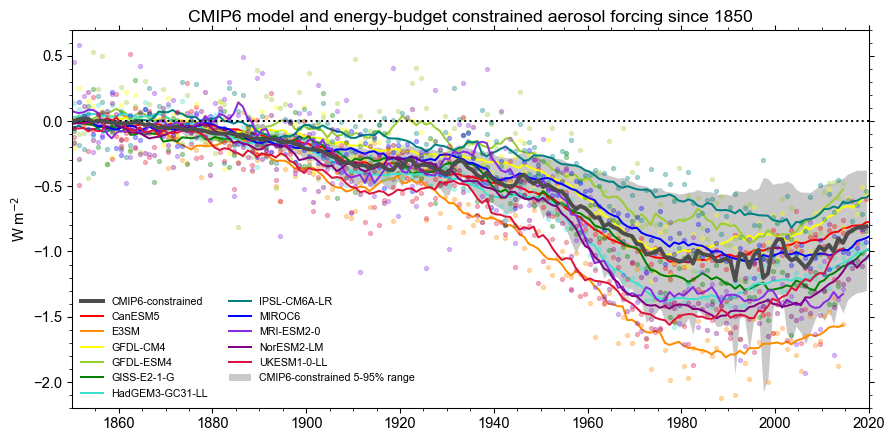

In [12]:
fig, axaer = pl.subplots(figsize=(24/2.54,12/2.54))

expt='CMIP6-constrained'
axaer.fill_between(np.arange(1850.5,2020), pc[expt]['multi']['ERFaer']['5'][100:]-pc[expt]['multi']['ERFaer']['5'][100], pc[expt]['multi']['ERFaer']['95'][100:]-pc[expt]['multi']['ERFaer']['95'][100], color=colors[expt], alpha=0.3, lw=0, label='CMIP6-constrained 5-95% range')

for expt in expts:
    if expt=='CMIP6-constrained':
        lw=3
        zorder=10
        axaer.plot(np.arange(1850.5,2020), np.nansum((ERFari[expt][100:270]-ERFari[expt][100]+ERFaci[expt][100:270]-ERFaci[expt][100])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)

    else:
        lw=1
        zorder=1
        axaer.plot(
            np.arange(startyear[expt]+0.5,endyear[expt]+1), 
            model_erf[expt], '.', lw=0, alpha=0.3, color=colors[expt]
        )
        axaer.plot(
            np.arange(startyear[expt]+0.5-10,endyear[expt]+1), 
            savgol_filter(
                np.concatenate(
                    (np.zeros(10), model_erf[expt], model_erf[expt][-1]*np.ones(10))
                ), 11, 1)[:-10],
            color=colors[expt], label=expt
        )
        
#         axaer.plot(np.arange(1750.5,2020), savgol_filter(np.nansum((ERFari[expt][:270]+ERFaci[expt][:270])*ks['multi'][expt], axis=1), 11, 1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)

axaer.set_xlim(1850,2020)
axaer.set_ylim(-2.2,0.7)
axaer.set_ylabel('W m$^{-2}$');
axaer.set_title('CMIP6 model and energy-budget constrained aerosol forcing since 1850')
axaer.axhline(0, ls=':', color='k')
axaer.legend(fontsize=8, frameon=False, ncol=2);

fig.tight_layout()
pl.savefig('../figures/models_v_constrained.png')